# DH Notebook Demo

## Keys to Using Daskhub

### s3 folder in your file explorer is connected to the s3 buckets 
- this allows you to copy files into these buckets without having to do anything fancy with aws cli (if you're comfortable with CLI, you can approach this how you normally would cp files from one directory to another)
- You can also just right-click on a file, "copy" and "paste" it to a folder in s3.
- **don't** try to open files in s3 directory (causes it to crash), just copy to read files (copy to your home dir to edit)

### The file explorer
- your home directory is private
- shared files can be stored in efs or s3

### Other
- connect with git for vcs
- Keep an eye on memory availability 
- be mindful of the server instance you are on
  - shut down server at the end of each use to minimize cost
- Use `pwd` in your notebook to see what dir your notebook is working in
- check what kernels are open on the left hand side

## Import packages

In [5]:
import rioxarray as rxr
import rasterio
from rasterio.plot import show, plotting_extent
from rasterio.crs import CRS
from rasterio.transform import Affine
import xarray as xr
import numpy as np

import os
import boto3
import s3fs
import fsspec
import glob
import pathlib

import dask.array
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import box, mapping, shape, Point, LineString, MultiPolygon, LinearRing, Polygon
import zarr
import cartopy.feature as cfeature
import warnings
# Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')
s3 = s3fs.S3FileSystem(anon=False)

## Read in data through S3

In [11]:
ds_file = s3.get_mapper("s3://dh-shift-curated/aviris/20220224/ang20220224t195402_100-100-100.zarr")
ds = xr.open_zarr(ds_file,decode_coords="all", consolidated=True)
ds

<xarray.Dataset>
Dimensions:      (x: 598, y: 5110, wavelength: 425)
Coordinates:
    band         (wavelength) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    fwhm         (wavelength) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    spatial_ref  int64 ...
  * wavelength   (wavelength) float64 377.1 382.1 387.1 ... 2.496e+03 2.501e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 594.5 595.5 596.5 597.5
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 5.108e+03 5.108e+03 5.11e+03
Data variables:
    Easting      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Elevation    (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Northing     (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Radiance     (x, y, wavelength) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    Reflectance  (x, y, wavelength) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>

In [31]:
#set dimensions and coordinates
ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y')
ds = ds.set_coords(("Easting", "Northing"))
ds

<xarray.Dataset>
Dimensions:      (x: 598, y: 5110, wavelength: 425)
Coordinates:
    Easting      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Northing     (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    band         (wavelength) int64 dask.array<chunksize=(100,), meta=np.ndarray>
    fwhm         (wavelength) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    spatial_ref  int64 ...
  * wavelength   (wavelength) float64 377.1 382.1 387.1 ... 2.496e+03 2.501e+03
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 594.5 595.5 596.5 597.5
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 5.108e+03 5.108e+03 5.11e+03
Data variables:
    Elevation    (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Radiance     (x, y, wavelength) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    Reflectance  (x, y, wavelength) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>

## Explore the dataset / Run any calculations

In [32]:
print("The CRS for zarr is:", ds.rio.crs)

The CRS for zarr is: EPSG:32610


In [33]:
ds.data_vars

Data variables:
    Elevation    (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Radiance     (x, y, wavelength) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    Reflectance  (x, y, wavelength) float32 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>

### Get NDVI (Normalized Difference Vegetation Index)

In [40]:
red = ds.sel(wavelength=630, method="nearest").Reflectance
nir = ds.sel(wavelength=750, method="nearest").Reflectance

In [41]:
ndvi = (nir - red) / (nir + red)
ndvi

<xarray.DataArray 'Reflectance' (x: 598, y: 5110)>
dask.array<truediv, shape=(598, 5110), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    Easting      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    Northing     (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    spatial_ref  int64 0
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 594.5 595.5 596.5 597.5
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 5.108e+03 5.108e+03 5.11e+03

### Plot index

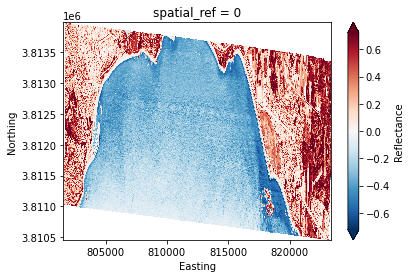

In [42]:
ndvi.plot.pcolormesh("Easting", "Northing", robust=True, add_colorbar=True);

------